In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import os
import pickle
import re
from datetime import datetime as dt

from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta

from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

In [7]:
with open('hourly_data.pkl', 'rb') as f:
    data_df = pickle.load(f)

### With Prophet

In [118]:
# Python
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [119]:
df1 = data_df.Count.resample('W').sum()
df = df1.copy()
# df = data_df.Count

In [120]:
df = df.reset_index()
df = df.rename(columns={'Time': 'ds', 'Count': 'y'})
df.head()

,ds,y
0,2015-01-04,594
1,2015-01-11,1718
2,2015-01-18,2092
3,2015-01-25,2527
4,2015-02-01,1058


In [121]:
# df.loc[df.TempC.isna(), 'TempC'] = df.TempC.mean()

In [122]:
m = Prophet(interval_width=0.95)
# m.add_regressor('TempC')
m.fit(df);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/cneiderer/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [123]:
# future = m.make_future_dataframe(periods=52*3, freq='w')
future = m.make_future_dataframe(periods=52, freq='w')
# future_temp = np.random.uniform(df.TempC.min(), df.TempC.max(), size=future.shape)
# future['TempC'] = future_temp
future.tail()

,ds
204,2018-12-02
205,2018-12-09
206,2018-12-16
207,2018-12-23
208,2018-12-30


In [130]:
max(future.ds)

Timestamp('2018-12-30 00:00:00')

In [124]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
204,2018-12-02,18377.205520,11243.867300,25180.493610
205,2018-12-09,15455.488671,8378.589060,21786.143426
206,2018-12-16,12957.607074,6095.638460,20016.010623
207,2018-12-23,10474.951606,3820.459189,17336.149009
208,2018-12-30,8254.203367,1463.582973,14727.092040


In [132]:
max(forecast.ds)

Timestamp('2018-12-30 00:00:00')

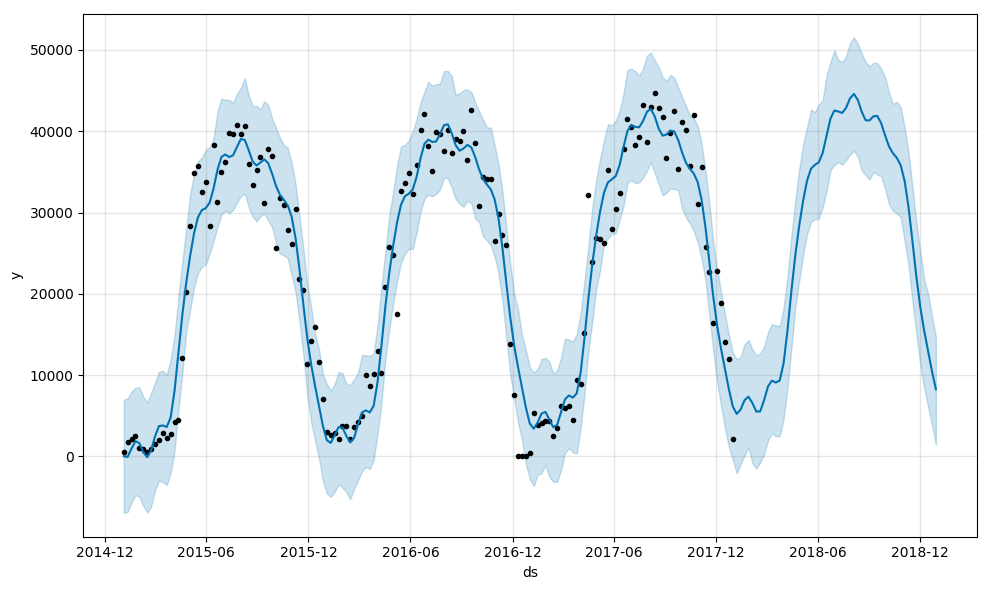

In [125]:
m.plot(forecast);

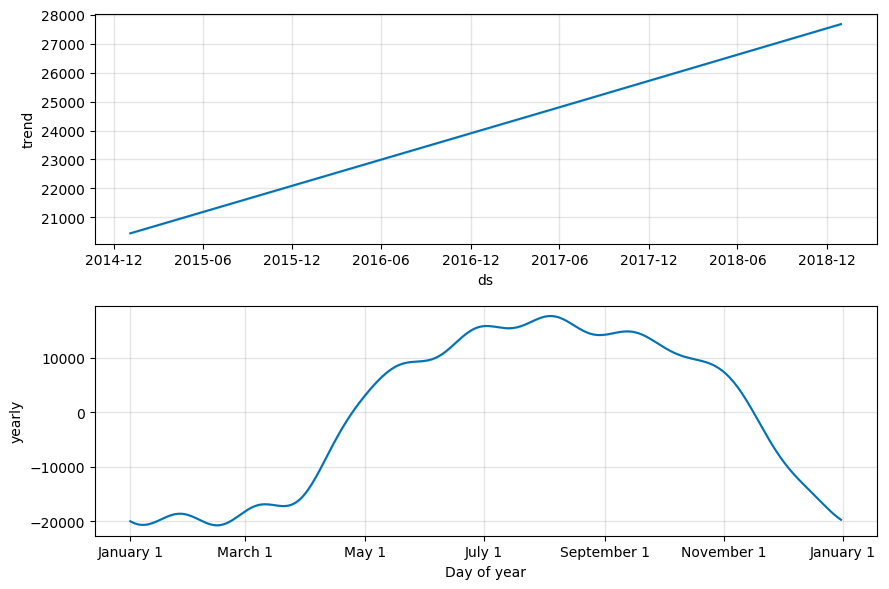

In [126]:
fig = m.plot_components(forecast);

In [133]:
forecast = forecast.set_index('ds', drop=True)
forecast

,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
ds,,,,,,,,,,,,,,,
2015-01-04,20453.407508,20453.407508,20453.407508,-6949.869855,6981.067433,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,29.508556
2015-01-11,20488.015649,20488.015649,20488.015649,-6821.862352,7132.068900,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-53.711488
2015-01-18,20522.623790,20522.623790,20522.623790,-5651.081542,7986.186151,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,985.341360
2015-01-25,20557.231930,20557.231930,20557.231930,-4768.287714,8461.396236,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,1884.630389
2015-02-01,20591.840071,20591.840071,20591.840071,-4950.567633,8493.908663,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,1628.473610
2015-02-08,20626.448212,20626.448212,20626.448212,-6062.121100,7375.042827,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,522.778276
2015-02-15,20661.056352,20661.056352,20661.056352,-6920.457406,6622.219657,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-88.145545
2015-02-22,20695.664493,20695.664493,20695.664493,-6215.458877,7779.488868,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,731.644707
2015-03-01,20730.272633,20730.272633,20730.272633,-4186.056389,9036.806920,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,2468.105213


In [134]:
max(forecast.index)

Timestamp('2018-12-30 00:00:00')

array([18000, 22000, 26000, 30000])

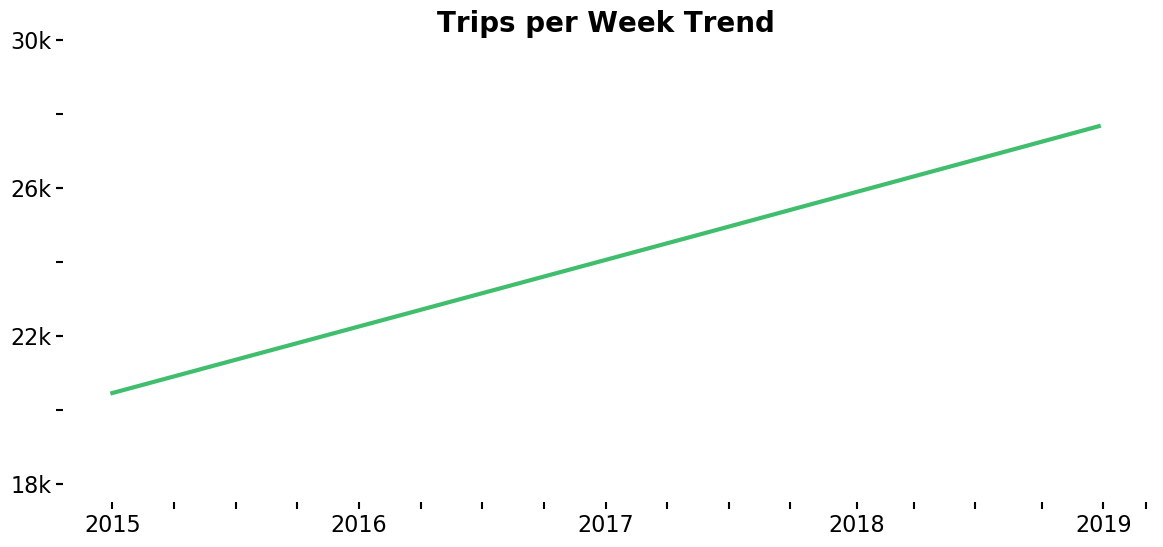

In [138]:
plt.style.use('default')
plt_color = '7d868c'
plt_color = 'white'
fig,ax = plt.subplots(figsize=(14,6), facecolor=plt_color)

forecast.trend.plot(color='#00a93d', lw=3, alpha=0.75, label='Forecast', ax=ax)

ax.set_title('Trips per Week Trend', fontdict={'size': 20, 'weight': 'bold'})

ax.set_xlabel('')

ax.set_yticks(np.arange(18000, 30001, 2000), minor=True)
ax.set_yticks(np.arange(18000, 30001, 4000), minor=False)
ax.set_yticklabels(['18k', '22k', '26k', '30k'], minor=False)
ax.set_ylim(bottom=17500, top=30000)

fs = 16
ax.tick_params(which='both', axis='both', labelsize=fs, width=1.5, length=5)
ax.set_frame_on(0)

ax.get_yticks()

In [55]:
forecast_data

,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
ds,,,,,,,,,,,,,,,
2015-01-04,20453.407508,20453.407508,20453.407508,-6473.726572,7068.843650,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,-20423.898952,29.508556
2015-01-11,20488.015649,20488.015649,20488.015649,-6742.899557,6330.850381,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-20541.727137,-53.711488
2015-01-18,20522.623790,20522.623790,20522.623790,-5690.742807,7956.091152,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,-19537.282430,985.341360
2015-01-25,20557.231930,20557.231930,20557.231930,-5343.708997,8592.391506,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,-18672.601542,1884.630389
2015-02-01,20591.840071,20591.840071,20591.840071,-5372.999406,8287.809938,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,-18963.366461,1628.473610
2015-02-08,20626.448212,20626.448212,20626.448212,-6401.816690,7487.863789,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,-20103.669936,522.778276
2015-02-15,20661.056352,20661.056352,20661.056352,-7222.648531,7109.909493,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-20749.201897,-88.145545
2015-02-22,20695.664493,20695.664493,20695.664493,-6439.667730,7509.082637,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,-19964.019786,731.644707
2015-03-01,20730.272633,20730.272633,20730.272633,-3990.376499,8677.706107,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,-18262.167420,2468.105213


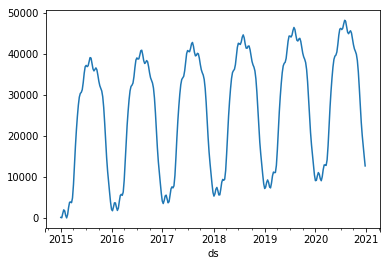

In [56]:
forecast_data[['trend', 'yearly']].sum(axis=1).plot()

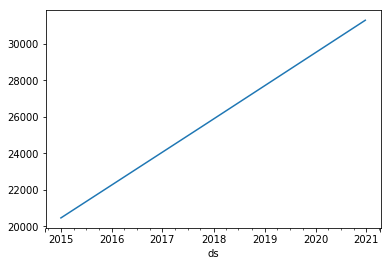

In [57]:
forecast_data.trend.plot()

In [52]:
test = forecast_data.reset_index()
test['Year'] = forecast_data.index.year
test['Month'] = forecast_data.index.month

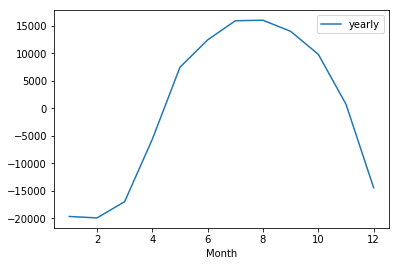

In [53]:
test[['Month', 'yearly']].groupby('Month').mean().plot()